# On va comparer la vitesse d'excecution du filtre de sobel partout , en cpu vs gpu
# pc de milan , i5 7300qh , gtx 1050ti 4gbvram

In [1]:
import numpy as np , matplotlib.pyplot as plt , cupy as cp , time ,cv2
from cupyx.scipy.ndimage import convolve

In [2]:
img = cv2.imread('31260198 [MConverter.eu].ppm', cv2.IMREAD_GRAYSCALE)

In [3]:
def sobelNUMPY(image):
    sobelX = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]], dtype=np.float32)
    sobelY = np.array([[ 1,  2,  1],[ 0,  0,  0],[-1, -2, -1]], dtype=np.float32)
    h, l = image.shape
    gradX = np.zeros((h, l), dtype=np.float32)
    gradY = np.zeros((h, l), dtype=np.float32)
    imagebord = np.pad(image, ((1, 1), (1, 1)), mode='edge')    #fonction deja implementé du bord lol
    for i in range(1, h + 1):
        for j in range(1, l + 1):
            zone = imagebord[i-1:i+2, j-1:j+2]
            gradX[i-1, j-1] = np.sum(zone * sobelX)
            gradY[i-1, j-1] = np.sum(zone * sobelY)

    gradient = np.hypot(gradX, gradY)
    gradient = gradient / gradient.max() * 255
    return gradient.astype(np.uint8)

In [4]:
def sobelCUPY(image):
    sobelX = cp.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]], dtype=cp.float32)

    sobelY = cp.array([[ 1,  2,  1],[ 0,  0,  0],[-1, -2, -1]], dtype=cp.float32)
    imagegpu = cp.array(image, dtype=cp.float32)
    h, l = image.shape
    gradX = cp.zeros((h, l), dtype=cp.float32)
    gradY = cp.zeros((h, l), dtype=cp.float32)
    imagebord = cp.pad(imagegpu, ((1, 1), (1, 1)), mode='edge')
    for i in range(1, h + 1):
        for j in range(1, l + 1):
            zone = imagebord[i-1:i+2, j-1:j+2]
            gradX[i-1, j-1] = cp.sum(zone * sobelX)
            gradY[i-1, j-1] = cp.sum(zone * sobelY)
    gradient = cp.hypot(gradX, gradY)
    gradient = gradient / gradient.max() * 255
    return gradient.astype(cp.uint8).get()

In [5]:
def moyennetemps(fonction, image, essais=5):
    total = 0
    for truc in range(essais):
        debut = time.time()
        fonction(image)
        fin = time.time()
        total += fin - debut
    return total / essais

In [6]:
CPU = moyennetemps(sobelNUMPY, img)
GPU = moyennetemps(sobelCUPY, img)

In [7]:
print("temps gpu = ",GPU)

temps gpu =  3.8437684059143065


In [8]:
print("temps cpu = ",CPU)

temps cpu =  0.29285564422607424


## ah , peutêtre la copie des éléments de la ram ddr3 vers la ram du gpu déja 
## pas vraiement exploitation du parrallelisme , pleins de boucles 

In [9]:
def sobelSUPERGPU(image):
    imagegpu = cp.array(image, dtype=cp.float32)
    sobelX = cp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=cp.float32)
    sobelY = cp.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=cp.float32)
    gx = convolve(imagegpu, sobelX)     #toute la difference 
    gy = convolve(imagegpu, sobelY)
    grad = cp.sqrt(gx ** 2 + gy ** 2)
    grad = grad / grad.max() * 255
    return grad.astype(cp.uint8).get()

In [11]:
CPU = moyennetemps(sobelNUMPY, img)
GPUNUL = moyennetemps(sobelCUPY, img)
GPUFORT = moyennetemps(sobelSUPERGPU, img)

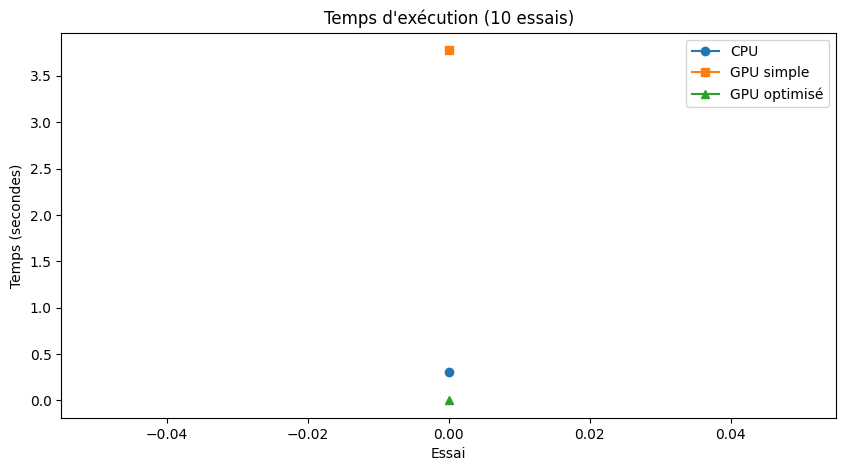

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(CPU, label='CPU', marker='o')
plt.plot(GPUNUL, label='GPU simple', marker='s')
plt.plot(GPUFORT, label='GPU optimisé', marker='^')
plt.title("Temps d'exécution (10 essais)")
plt.xlabel("Essai")
plt.ylabel("Temps (secondes)")
plt.legend()
plt.show()

In [13]:
CPU/GPUFORT

186.12034611649057

# On gagne 20 pourcent de vitesse grace à ca . faudra tester sur une image super grande

In [14]:
truc = 'pexels-pixabay-86594.jpg'
img1 = cv2.imread(truc, cv2.IMREAD_GRAYSCALE).astype(np.float64)

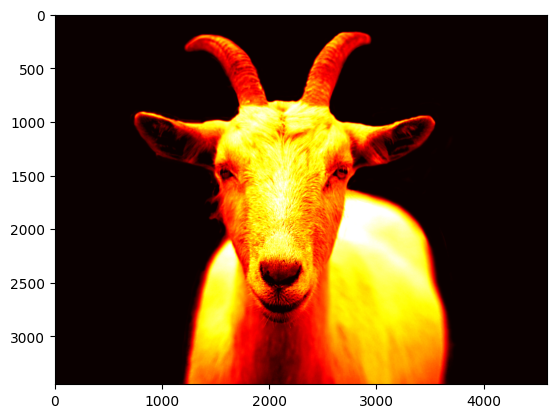

In [15]:
plt.imshow(img1,cmap = 'hot')

In [ ]:
CPU = moyennetemps(sobelNUMPY, img1)

In [ ]:
GPUNUL = moyennetemps(sobelCUPY, img1)

In [ ]:
GPUFORT = moyennetemps(sobelSUPERGPU, img1)

In [ ]:
CPU/GPUFORT

## Ca prends beaucoup trop de temps avec une image en 4k . On essaye 1080p 

In [10]:
truc = 'pexels-pixabay-144240.jpg'
img2 = cv2.imread(truc, cv2.IMREAD_GRAYSCALE).astype(np.float64)

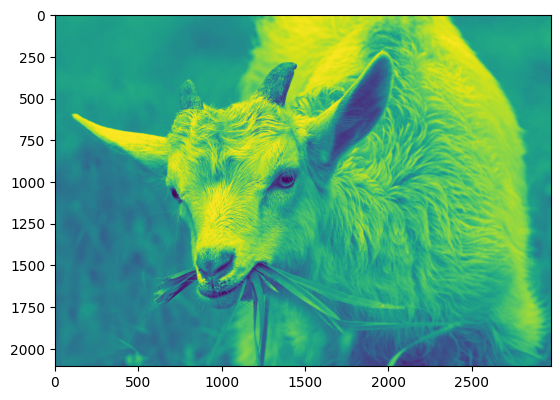

In [11]:
plt.imshow(img2)

In [12]:
CPU = moyennetemps(sobelNUMPY, img2)

In [ ]:
GPUNUL = moyennetemps(sobelCUPY, img2)#### trop trop long

In [13]:
GPUFORT = moyennetemps(sobelSUPERGPU, img2)

In [14]:
CPU

75.95852251052857

In [15]:
GPUFORT

0.03062124252319336

In [16]:
CPU/GPUFORT

2480.5826364817012

### 2480 FOIS PLUS RAPIDE ? ON DIRAIT QUE C'EST MEME TROP EFFICACE ET JE TROUVE CA PLUTOT LOUCHE